# Exploratory Data Analysis of HAR70+ Dataset
Dataset can be found [here](https://archive.ics.uci.edu/dataset/780/har70). (corresponding [paper](https://www.mdpi.com/1424-8220/23/5/2368))

**Table of Contents**
1. [Imports](#0-imports)

## Dataset Information 
(taken from link)
For what purpose was the dataset created?

The purpose was to train machine learning models for human activity recognition on professionally-annotated accelerometer data of fit-to-frail older adults.

Additional Information

The HAR70+ dataset contains recordings of 18 older adult participants wearing two 3-axial Axivity AX3 accelerometers for around 40 minutes in a semi-structured free-living setting. The participants' age was between 70 and 95 years. Five of the 18 subjects used walking aids during data recording. One sensor was attached to the right front thigh and the other to the lower back. The provided sampling rate is 50Hz. Video recordings of a chest-mounted camera were used to annotate the performed activities frame-by-frame.

Each subject's recordings are provided in a separate .csv file. One such .csv file contains the following columns:
1. timestamp: date and time of recorded sample
2. back_x: acceleration of back sensor in x-direction (down) in the unit g
3. back_y: acceleration of back sensor in y-direction (left) in the unit g
4. back_z: acceleration of back sensor in z-direction (forward) in the unit g
5. thigh_x: acceleration of thigh sensor in x-direction (down) in the unit g
6. thigh_y: acceleration of thigh sensor in y-direction (right) in the unit g
7. thigh_z: acceleration of thigh sensor in z-direction (backward) in the unit g
8. label: annotated activity code

The dataset contains the following annotated activities with the corresponding coding scheme:
1: walking	
3: shuffling
4: stairs (ascending)	
5: stairs (descending)	
6: standing	
7: sitting	
8: lying

## 1. Imports

In [35]:
# Pandas
import pandas as pd
# PyTorch
import torch
from torch.utils.data import Dataset
# MatPlotLib
import matplotlib.pyplot as plt
# Typing
from typing import *

import src.utils as utils

In [36]:
utils.download_har70plus_dataset()

Download complete: data/har70.zip
Files extracted to: data


## 2. Examine Dataset
The dataset consists of 18 separate `csv` files (`501.csv` to `518.csv`), one for each subject.

In [9]:
# Load all 18 datasets
df_dict: Dict[int, pd.DataFrame]= {}
for subject_code in range(501, 519):
    file_path = f"data/har70plus/{subject_code}.csv" 
    df_dict[subject_code] = pd.read_csv(file_path)

In [10]:
# Examine one csv (subject data)
df = df_dict[501]
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6


In [28]:
# Check for missing values in all csv files
total_missing = pd.Series(dtype=int)
for df in df_dict.values():
    missing_counts = df.isnull().sum()
    total_missing = total_missing.add(missing_counts, fill_value=0)

total_missing = total_missing.astype(int)
total_missing

back_x            0
back_y            0
back_z            0
label             0
thigh_x           0
thigh_y           0
thigh_z           0
timestamp         0
timestamp_diff    1
dtype: int64

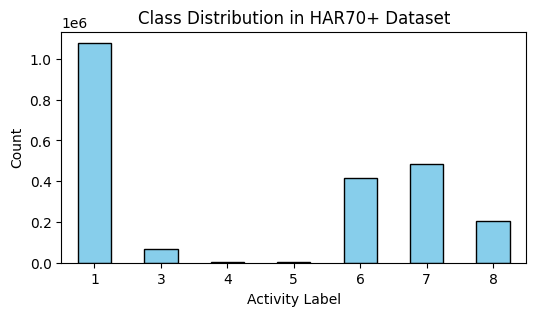

label
1    1079312
3      66058
4       4560
5       4978
6     418055
7     483452
8     203182
dtype: int64

In [30]:
total_counts = pd.Series(dtype=int)
for df in df_dict.values():
    counts = df["label"].value_counts()
    total_counts = total_counts.add(counts, fill_value=0) # `add` automatically aligns indices before summing counts

total_counts = total_counts.astype(int)

plt.figure(figsize=(6, 3))
total_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Activity Label")
plt.ylabel("Count")
plt.title("Class Distribution in HAR70+ Dataset")
plt.xticks(rotation=0)
plt.show()
total_counts


In [13]:
df['timestamp'].head()

0    2021-06-11 10:24:37.958
1    2021-06-11 10:24:37.979
2    2021-06-11 10:24:37.999
3    2021-06-11 10:24:38.019
4    2021-06-11 10:24:38.039
Name: timestamp, dtype: object

In [15]:
# Check timestamp format
print(df['timestamp'].head())

0    2021-06-11 10:24:37.958
1    2021-06-11 10:24:37.979
2    2021-06-11 10:24:37.999
3    2021-06-11 10:24:38.019
4    2021-06-11 10:24:38.039
Name: timestamp, dtype: object


- dataset has average time interval of 0.020 seconds (20 milliseconds) between consecutive samples, which aligns with the 50HZ sampling rate (1/50 = 0.02 seconds). However, there are occasionally larger gaps (up to 4.86 seconds), which might be due to pauses in recording or data. 
- fixed size sequences: sliding window
- many to one model

In [16]:
# Convert timestamp to datetime and calculate time differences
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_diff'] = df['timestamp'].diff().dt.total_seconds()

# Summary statistics of timestamp gaps
print(df['timestamp_diff'].describe())

# Identify breakpoints (where gaps are larger than expected 0.02s)
gap_threshold = 0.05  # Slightly higher than 0.02 to account for minor variations
breakpoints = df[df['timestamp_diff'] > gap_threshold].index

# Print breakpoints
print(f"Identified {len(breakpoints)} breakpoints at indices:", breakpoints.tolist())

count    141713.000000
mean          0.020578
std           0.121197
min           0.019000
25%           0.020000
50%           0.020000
75%           0.020000
max          40.420000
Name: timestamp_diff, dtype: float64
Identified 8 breakpoints at indices: [6353, 22467, 31345, 44355, 54457, 79677, 81581, 137429]


In [17]:
df["timestamp"].iloc[11600: 11610]

11600   2021-03-24 14:45:57.000
11601   2021-03-24 14:45:57.020
11602   2021-03-24 14:45:57.040
11603   2021-03-24 14:45:57.060
11604   2021-03-24 14:45:57.080
11605   2021-03-24 14:45:57.099
11606   2021-03-24 14:45:59.159
11607   2021-03-24 14:45:59.180
11608   2021-03-24 14:45:59.200
11609   2021-03-24 14:45:59.220
Name: timestamp, dtype: datetime64[ns]

In [ ]:
class HARSegmentedDataset(Dataset):
    def __init__(self, df, window_size=100, stride=50, gap_threshold=0.05):
        self.window_size = window_size
        self.stride = stride
        
        # Convert timestamp and calculate time gaps
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['timestamp_diff'] = df['timestamp'].diff().dt.total_seconds()
        
        # Identify breakpoints (indices where gaps exceed threshold)
        breakpoints = df[df['timestamp_diff'] > gap_threshold].index.tolist()
        
        # Split data into continuous segments
        segments = []
        start_idx = 0
        for bp in breakpoints:
            segments.append(df.iloc[start_idx:bp])  # Add previous segment
            start_idx = bp  # Start new segment
        segments.append(df.iloc[start_idx:])  # Add last segment
        
        # Extract valid sequences from each segment
        self.sequences, self.targets = [], []
        sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
        label_col = 'label'

        for segment in segments:
            data = segment[sensor_cols].values
            labels = segment[label_col].values

            # Ensure segment is long enough for at least one full window
            if len(data) < window_size:
                continue  

            for i in range(0, len(data) - window_size + 1, stride):
                self.sequences.append(data[i : i + window_size])
                self.targets.append(labels[i + window_size - 1])  # Many-to-One

        # Convert to tensors
        self.sequences = torch.tensor(self.sequences, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Example Usage
dataset = HARSegmentedDataset(df, window_size=100, stride=50)
print(f"Total valid sequences: {len(dataset)}")